# Mnohonásobná regrese s hodnocením statistické významnosti

## Úkol 2

1. **Načtení dat**: Stáhněte si datovou sadu House_price.csv a načtěte ji do svého prostředí pro analýzu
2. **Průzkum dat**: Prozkoumejte načtená data, identifikujte a odstraňte sloupce, které nejsou informativní pro vytvoření modelu
3. **Analýza dat**:
    * Analyzujte data na přítomnost multikolinearity a nutnost normalizace
    * Použijte statistické metody k identifikaci potřeby transformace dat.
4. **Vytvoření regresních modelů**:
    * Rozdělení dat na trénovací a testovací množinu (70/30).
    * Vytvořte model mnohonásobné regrese se všemi relevantními atributy.
    * Proveďte testování statistické významnosti koeficientů.
    * Analyzujte celkovou kvalitu modelu pomocí.
    * Vyhodnoťte výkon modelu pomocí metrik (RMSE, R²) a interpretujte výsledky.
5. Porovnání výsledků.

In [1]:
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from pyloess import loess
import statsmodels.api as sm
import pingouin as pg
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('default')
sns.set_style("whitegrid")

# Constants
DATASET_DIR = Path("datasets")
DATASET_DIR.mkdir(exist_ok=True)
DATASET = DATASET_DIR / "house_data.csv"
DATASET_URL = "https://drive.google.com/drive/folders/1gK5IsrYbTguM5rmjFpmrYXOOF_33K5sh"
TEST_SIZE = 0.3
RANDOM_STATE = 42


In [2]:
# Download data if needed
if not DATASET.exists():
    gdown.download_folder(url=DATASET_URL, output=str(DATASET_DIR), use_cookies=False)

# Load housing dataset
df = pd.read_csv(DATASET)
print("Housing dataset info:")
print(df.info())
print(f"\nDataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())



Housing dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NX       506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB
None

Dataset shape: (506, 14)

First 5 rows:
      CRIM    ZN  INDUS  CHAS     NX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.

In [3]:
# Data exploration and preprocessing
print("\nDataset Statistics:")
print(df.describe())

# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum()}")

# Check data types and unique values for categorical columns
print("\nData types:")
print(df.dtypes)

# Identify non-informative columns (high cardinality, unique identifiers, etc.)
print("\nUnique values per column:")
for col in df.columns:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} unique values")
    if unique_count == len(df):
        print(f"  -> {col} appears to be a unique identifier")
    elif unique_count == 1:
        print(f"  -> {col} has constant value")




Dataset Statistics:
             CRIM          ZN       INDUS        CHAS          NX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std   

In [4]:
# Boston Housing dataset - no columns to remove (all are informative)
print(f"\nDataset shape after cleanup: {df.shape}")
print("Column descriptions:")
column_descriptions = {
    'CRIM': 'Per capita crime rate',
    'ZN': 'Proportion of residential land zoned for lots over 25,000 sq.ft.',
    'INDUS': 'Proportion of non-retail business acres',
    'CHAS': 'Charles River dummy variable (1 if tract bounds river)',
    'NX': 'Nitric oxides concentration (parts per 10 million)',
    'RM': 'Average number of rooms per dwelling',
    'AGE': 'Proportion of owner-occupied units built prior to 1940',
    'DIS': 'Weighted distances to employment centres',
    'RAD': 'Index of accessibility to radial highways',
    'TAX': 'Property tax rate per $10,000',
    'PTRATIO': 'Pupil-teacher ratio by town',
    'B': '1000(Bk - 0.63)^2 where Bk is proportion of blacks',
    'LSTAT': 'Lower status of population (percent)',
    'MEDV': 'Median value of owner-occupied homes in $1000s (TARGET)'
}

for col, desc in column_descriptions.items():
    print(f"{col}: {desc}")

# All columns are informative for Boston Housing dataset
print("\nAll columns are informative - no removal needed.")




Dataset shape after cleanup: (506, 14)
Column descriptions:
CRIM: Per capita crime rate
ZN: Proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS: Proportion of non-retail business acres
CHAS: Charles River dummy variable (1 if tract bounds river)
NX: Nitric oxides concentration (parts per 10 million)
RM: Average number of rooms per dwelling
AGE: Proportion of owner-occupied units built prior to 1940
DIS: Weighted distances to employment centres
RAD: Index of accessibility to radial highways
TAX: Property tax rate per $10,000
PTRATIO: Pupil-teacher ratio by town
B: 1000(Bk - 0.63)^2 where Bk is proportion of blacks
LSTAT: Lower status of population (percent)
MEDV: Median value of owner-occupied homes in $1000s (TARGET)

All columns are informative - no removal needed.


In [5]:
# Target variable is MEDV (Median home value)
target_col = 'MEDV'
print(f"\nTarget variable: {target_col}")

# Separate features and target
y = df[target_col]
X_initial = df.drop(columns=[target_col])

print(f"Feature columns: {X_initial.columns.tolist()}")



Target variable: MEDV
Feature columns: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


In [6]:
# All features are numerical - no categorical encoding needed
X_encoded = X_initial.copy()
print(f"All features are numerical. Final feature count: {X_encoded.shape[1]}")



All features are numerical. Final feature count: 13



EXPLORATORY DATA ANALYSIS


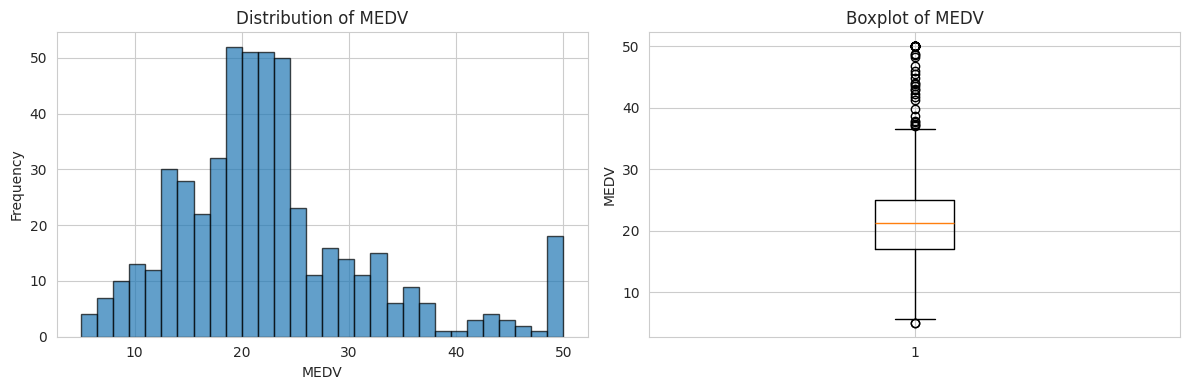


Correlation with target variable:
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NX        -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
dtype: float64


In [7]:
# Exploratory Data Analysis
print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Distribution of target variable
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(y, bins=30, edgecolor='black', alpha=0.7)
plt.title(f'Distribution of {target_col}')
plt.xlabel(target_col)
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(y)
plt.title(f'Boxplot of {target_col}')
plt.ylabel(target_col)
plt.tight_layout()
plt.show()

# Correlation matrix
correlation_matrix = X_encoded.corrwith(y).sort_values(ascending=False)
print(f"\nCorrelation with target variable:")
print(correlation_matrix)




Creating pairplot for top correlated features: ['LSTAT', 'RM', 'PTRATIO', 'INDUS', 'TAX']


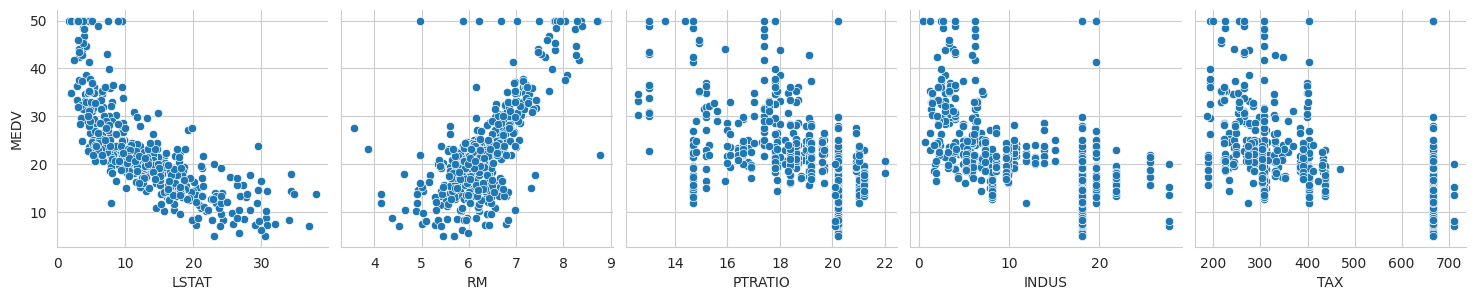

In [8]:
# Pairplot for selected features (top correlated)
top_features = correlation_matrix.abs().nlargest(min(5, len(correlation_matrix))).index.tolist()
plot_data = pd.concat([X_encoded[top_features], y], axis=1)

print(f"\nCreating pairplot for top correlated features: {top_features}")
sns.pairplot(plot_data, x_vars=top_features, y_vars=target_col, height=3, aspect=1, kind='scatter')
plt.show()



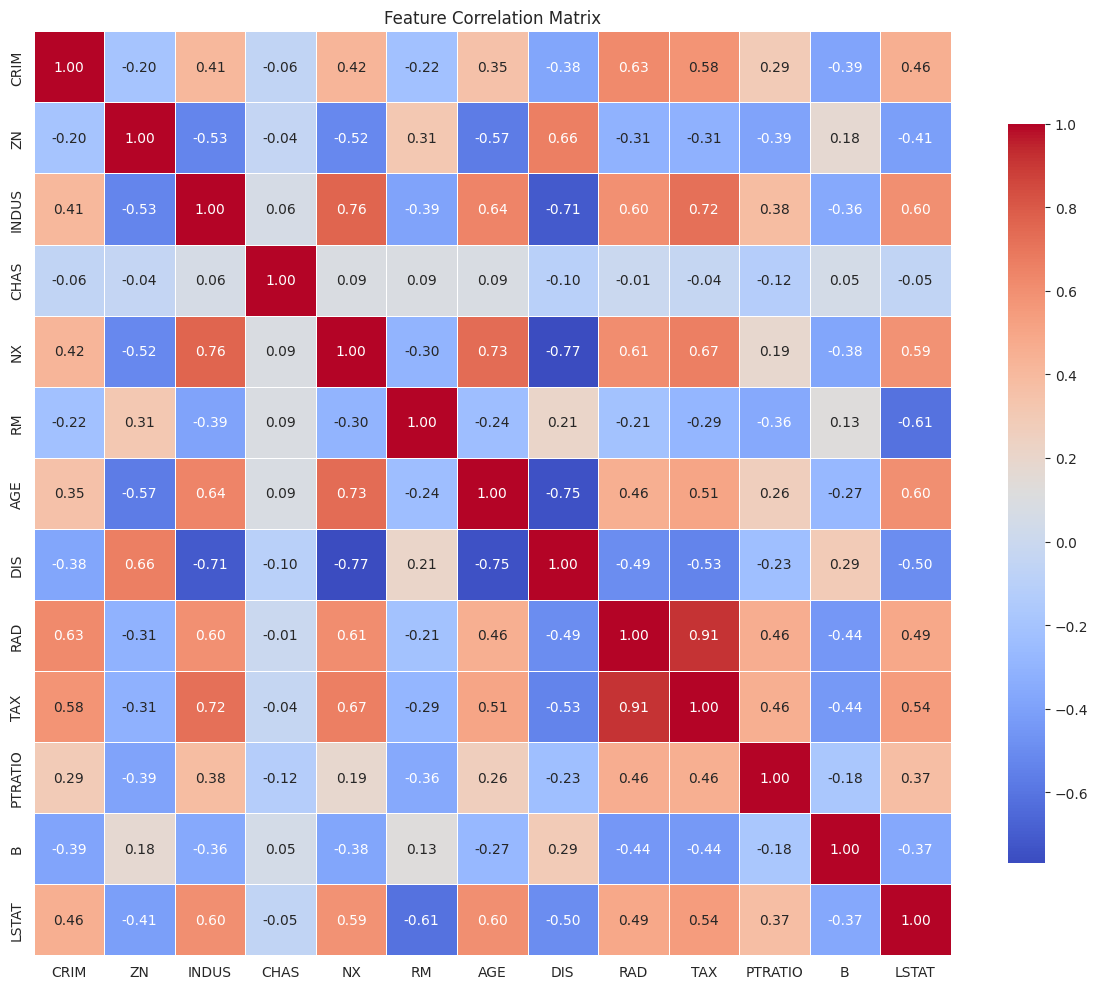

In [9]:
# Full correlation matrix heatmap
plt.figure(figsize=(12, 10))
correlation_matrix_full = X_encoded.corr()
sns.heatmap(correlation_matrix_full, annot=True, cmap='coolwarm', fmt=".2f", 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()



In [10]:
# Multicollinearity analysis using VIF
print("\n" + "="*50)
print("MULTICOLLINEARITY ANALYSIS")
print("="*50)

# Calculate VIF for each feature
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                       for i in range(len(X.columns))]
    return vif_data.sort_values('VIF', ascending=False)

vif_scores = calculate_vif(X_encoded)
print("Variance Inflation Factors:")
print(vif_scores)

# Remove highly collinear features (VIF > 10)
high_vif_features = vif_scores[vif_scores['VIF'] > 10]['Feature'].tolist()
if high_vif_features:
    print(f"\nRemoving features with high VIF (>10): {high_vif_features}")
    X_reduced = X_encoded.drop(columns=high_vif_features)
else:
    X_reduced = X_encoded.copy()

print(f"Features after multicollinearity removal: {X_reduced.shape[1]}")




MULTICOLLINEARITY ANALYSIS
Variance Inflation Factors:
    Feature        VIF
10  PTRATIO  85.029547
5        RM  77.948283
4        NX  73.894947
9       TAX  61.227274
6       AGE  21.386850
11        B  20.104943
8       RAD  15.167725
7       DIS  14.699652
2     INDUS  14.485758
12    LSTAT  11.102025
1        ZN   2.844013
0      CRIM   2.100373
3      CHAS   1.152952

Removing features with high VIF (>10): ['PTRATIO', 'RM', 'NX', 'TAX', 'AGE', 'B', 'RAD', 'DIS', 'INDUS', 'LSTAT']
Features after multicollinearity removal: 3



DATA NORMALIZATION ANALYSIS


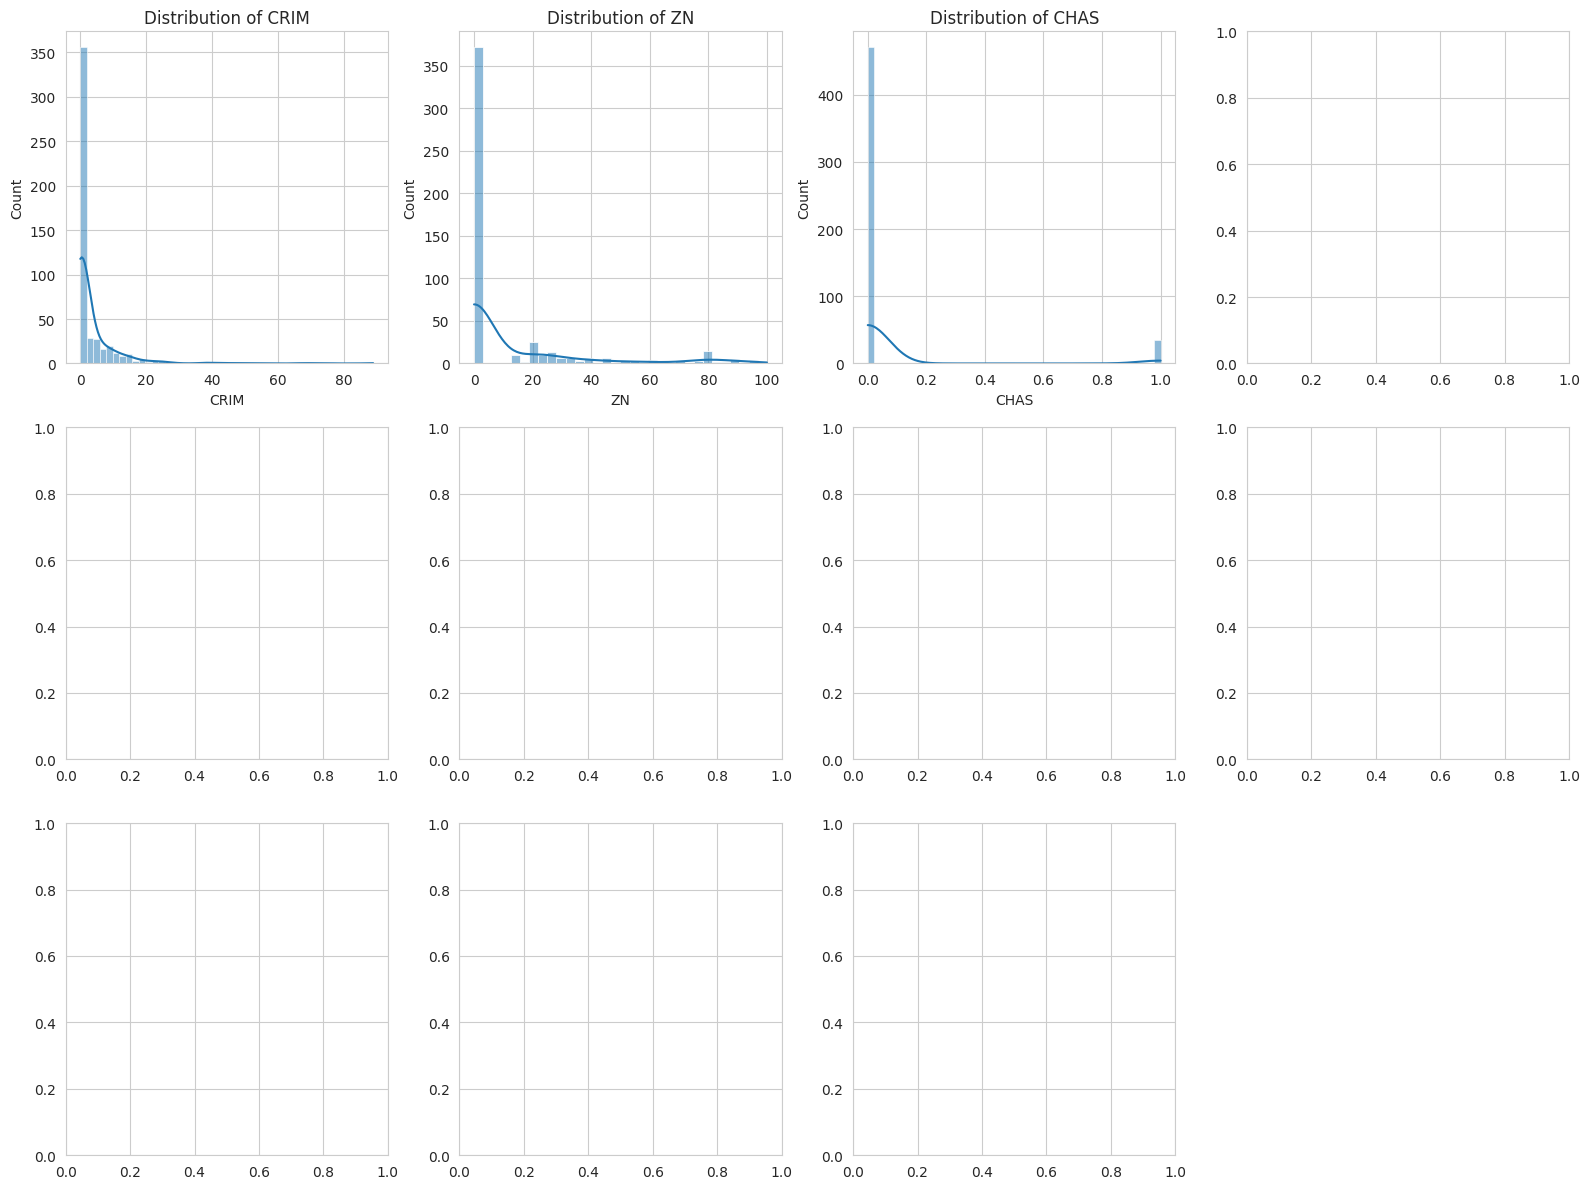

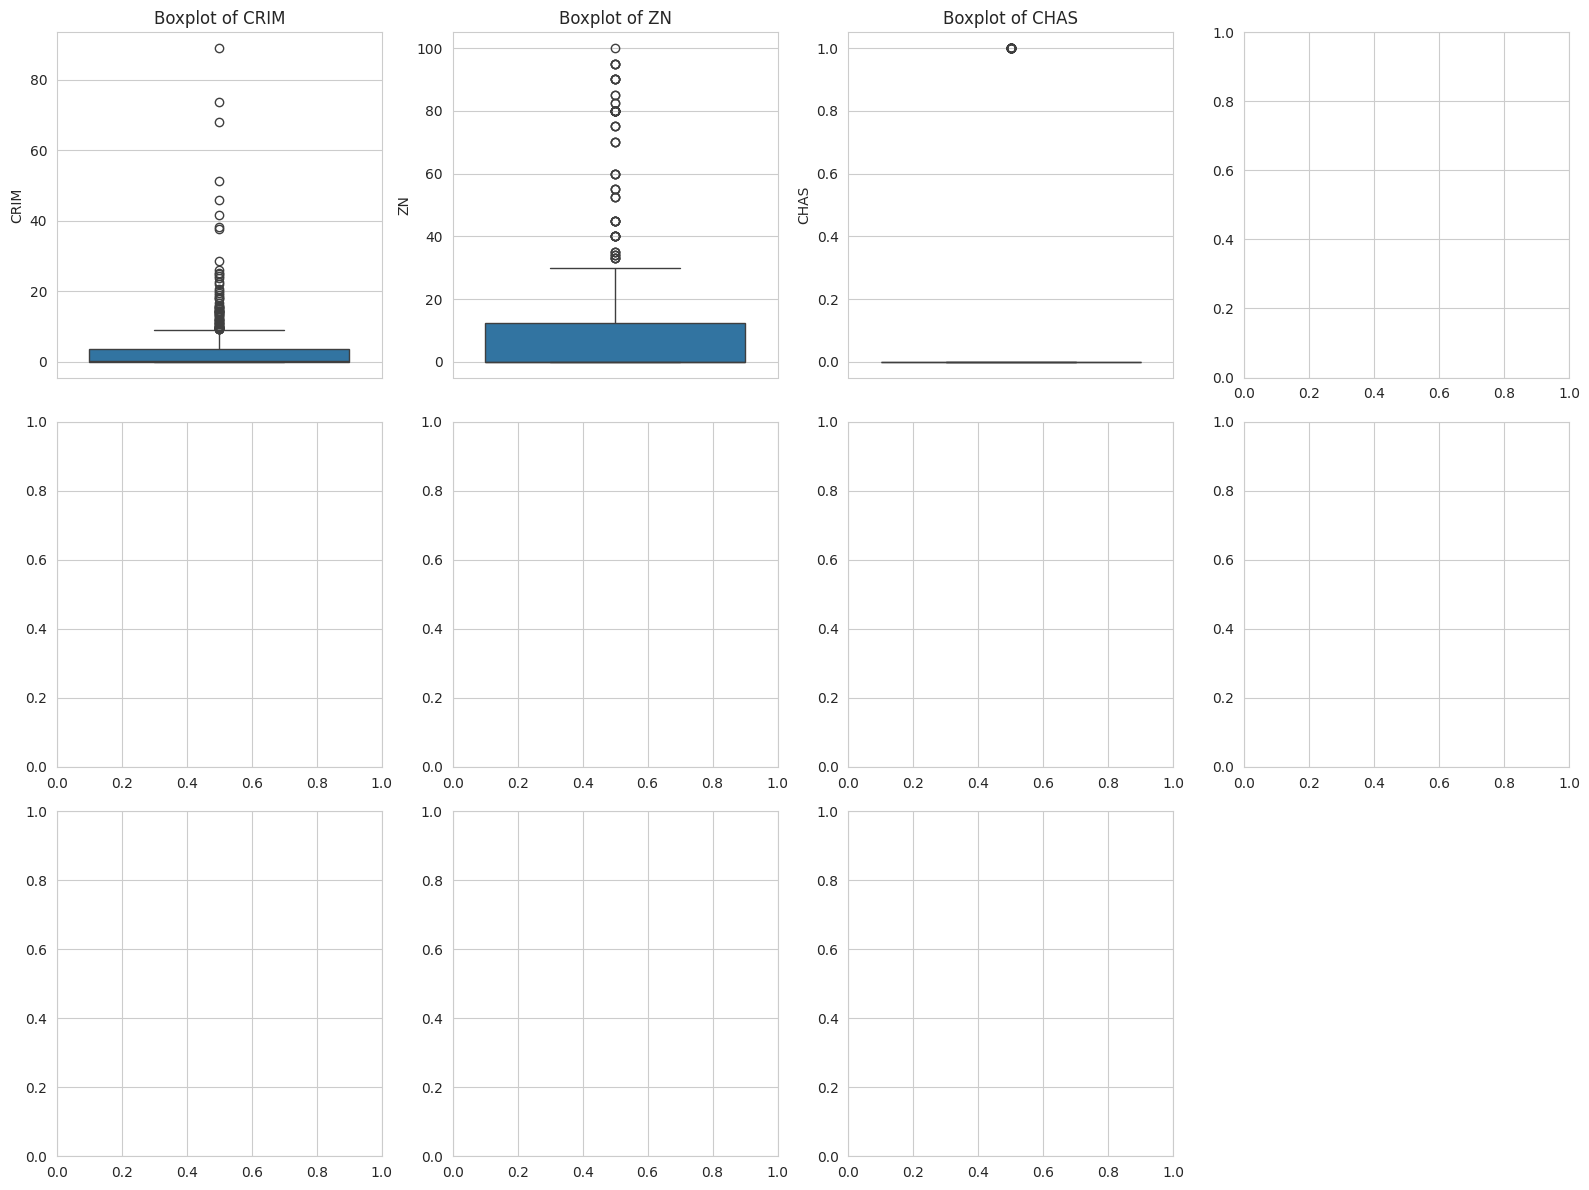

In [11]:
# Normality tests and data transformation analysis
print("\n" + "="*50)
print("DATA NORMALIZATION ANALYSIS")
print("="*50)

# Check distributions of all numerical features
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for i, col in enumerate(X_reduced.columns):
    sns.histplot(X_reduced[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')

# Remove last empty subplot
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

# Boxplots for all features
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for i, col in enumerate(X_reduced.columns):
    sns.boxplot(data=X_reduced[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

# Remove last empty subplot  
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()



In [12]:
# Data normalization
print("Applying data normalization...")

# Standard Scaler
scaler_std = StandardScaler()
X_std = pd.DataFrame(scaler_std.fit_transform(X_reduced), 
                     columns=X_reduced.columns, index=X_reduced.index)

# Min-Max Scaler
scaler_minmax = MinMaxScaler()
X_minmax = pd.DataFrame(scaler_minmax.fit_transform(X_reduced), 
                        columns=X_reduced.columns, index=X_reduced.index)

print("Standardized data statistics:")
print(X_std.describe())



Applying data normalization...
Standardized data statistics:
               CRIM            ZN          CHAS
count  5.060000e+02  5.060000e+02  5.060000e+02
mean  -1.123388e-16  7.898820e-17 -3.510587e-17
std    1.000990e+00  1.000990e+00  1.000990e+00
min   -4.197819e-01 -4.877224e-01 -2.725986e-01
25%   -4.109696e-01 -4.877224e-01 -2.725986e-01
50%   -3.906665e-01 -4.877224e-01 -2.725986e-01
75%    7.396560e-03  4.877224e-02 -2.725986e-01
max    9.933931e+00  3.804234e+00  3.668398e+00


In [13]:
# Split data into training and testing sets
print("\n" + "="*50)
print("MODEL TRAINING AND EVALUATION")
print("="*50)

X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")



MODEL TRAINING AND EVALUATION
Training set size: (354, 3)
Test set size: (152, 3)


In [14]:
# Multiple Linear Regression Model
print("\n1. Multiple Linear Regression Model")
print("-" * 40)

model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluation metrics
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Training RMSE: {rmse_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Training R²: {r2_train:.4f}")
print(f"Test R²: {r2_test:.4f}")

print(f"\nModel Intercept: {model.intercept_:.4f}")
print("Model Coefficients:")
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)
print(coef_df)



1. Multiple Linear Regression Model
----------------------------------------
Training RMSE: 8.0660
Test RMSE: 7.5507
Training R²: 0.2598
Test R²: 0.2349

Model Intercept: 22.9260
Model Coefficients:
  Feature  Coefficient
0    CRIM    -3.059144
1      ZN     2.630131
2    CHAS     2.024119


In [15]:
# Statistical significance testing using statsmodels
print("\n2. Statistical Significance Testing")
print("-" * 40)

X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model_sm = sm.OLS(y_train, X_train_sm).fit()
print(model_sm.summary())

# Predictions with statsmodels
y_pred_test_sm = model_sm.predict(X_test_sm)
rmse_test_sm = np.sqrt(mean_squared_error(y_test, y_pred_test_sm))
r2_test_sm = r2_score(y_test, y_pred_test_sm)

print(f"\nStatsmodels Test RMSE: {rmse_test_sm:.4f}")
print(f"Statsmodels Test R²: {r2_test_sm:.4f}")



2. Statistical Significance Testing
----------------------------------------
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     40.95
Date:                Sat, 16 Aug 2025   Prob (F-statistic):           1.05e-22
Time:                        16:20:58   Log-Likelihood:                -1241.3
No. Observations:                 354   AIC:                             2491.
Df Residuals:                     350   BIC:                             2506.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

In [16]:
# Partial correlation analysis
print("\n3. Partial Correlation Analysis")
print("-" * 40)

# Create dataframe with all variables
analysis_data = X_std.copy()
analysis_data[target_col] = y

# Calculate partial correlations for top features
top_features_for_partial = coef_df.head(5)['Feature'].tolist()

for feature in top_features_for_partial:
    other_features = [f for f in top_features_for_partial if f != feature]
    if len(other_features) > 0:
        partial_corr = pg.partial_corr(
            data=analysis_data, 
            x=feature, 
            y=target_col, 
            covar=other_features
        )
        print(f"\nPartial correlation between {target_col} and {feature}:")
        print(f"Coefficient: {partial_corr['r'].iloc[0]:.4f}")
        print(f"P-value: {partial_corr['p-val'].iloc[0]:.4f}")




3. Partial Correlation Analysis
----------------------------------------

Partial correlation between MEDV and CRIM:
Coefficient: -0.3403
P-value: 0.0000

Partial correlation between MEDV and ZN:
Coefficient: 0.3273
P-value: 0.0000

Partial correlation between MEDV and CHAS:
Coefficient: 0.1942
P-value: 0.0000



4. Model Diagnostics
----------------------------------------


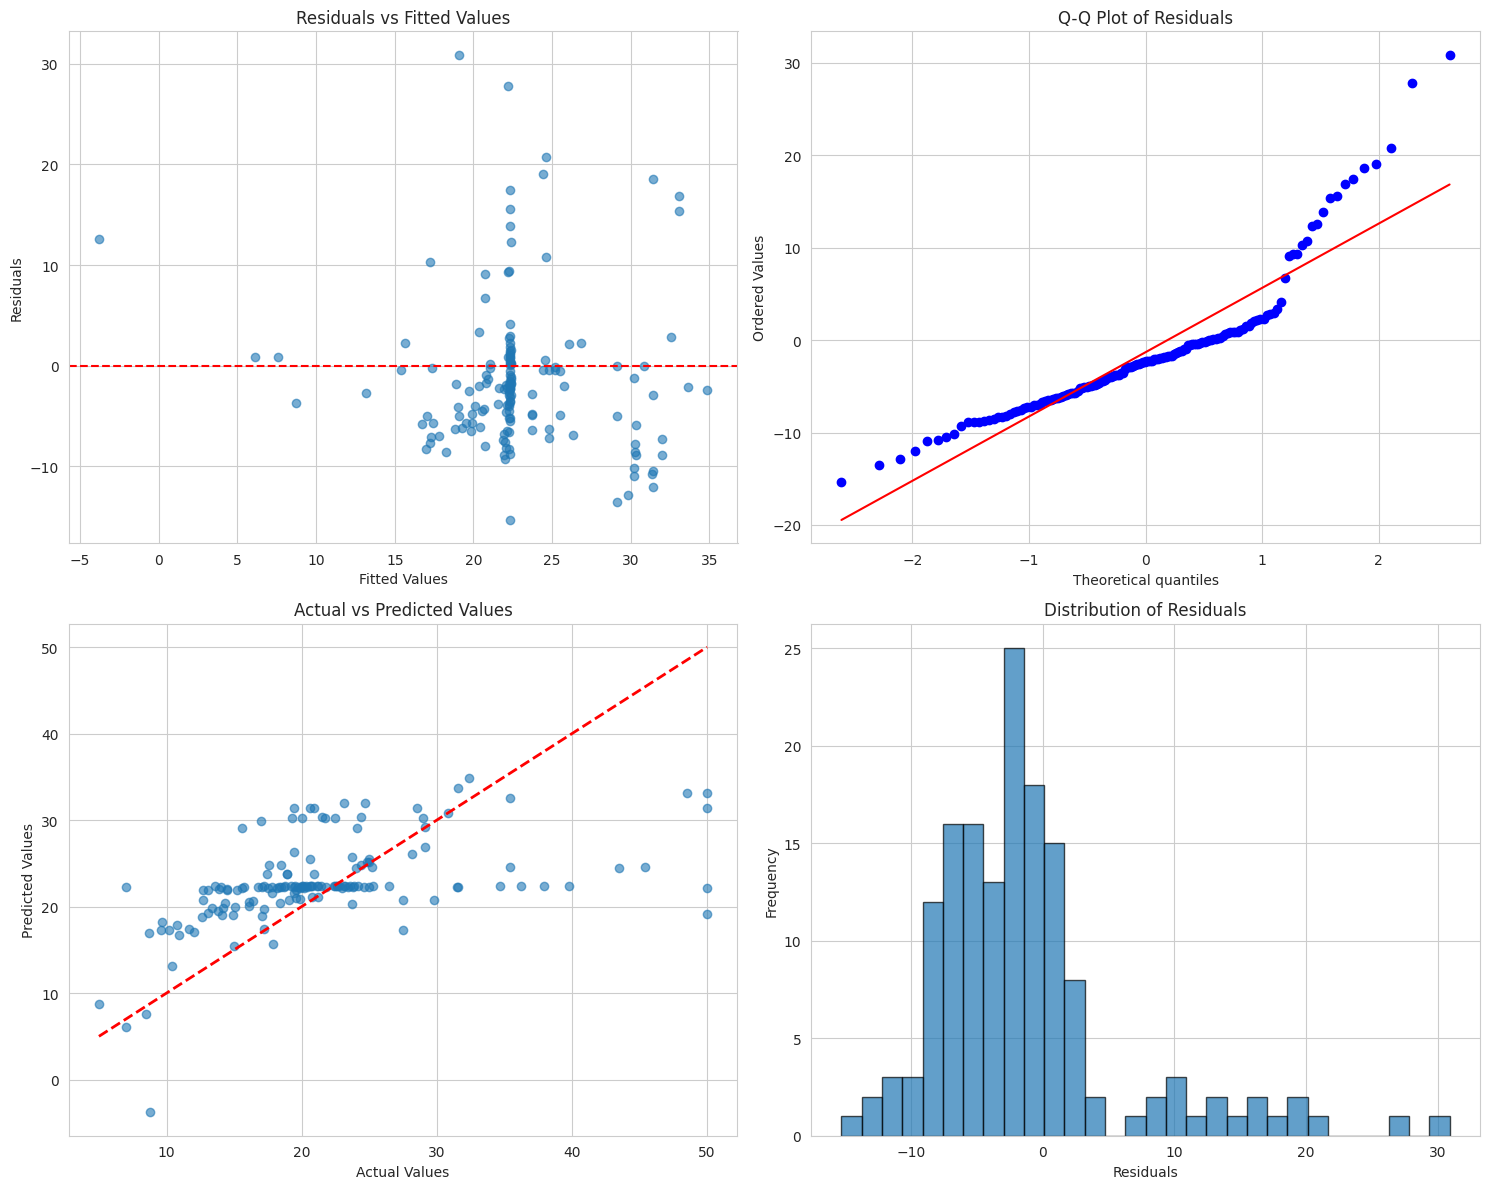

In [17]:
# Model diagnostic plots
print("\n4. Model Diagnostics")
print("-" * 40)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Residuals vs Fitted
residuals = y_test - y_pred_test
axes[0, 0].scatter(y_pred_test, residuals, alpha=0.6)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted Values')

# Q-Q plot of residuals
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot of Residuals')

# Actual vs Predicted
axes[1, 0].scatter(y_test, y_pred_test, alpha=0.6)
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Values')
axes[1, 0].set_ylabel('Predicted Values')
axes[1, 0].set_title('Actual vs Predicted Values')

# Residuals histogram
axes[1, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Residuals')

plt.tight_layout()
plt.show()




5. Feature Importance Analysis
----------------------------------------


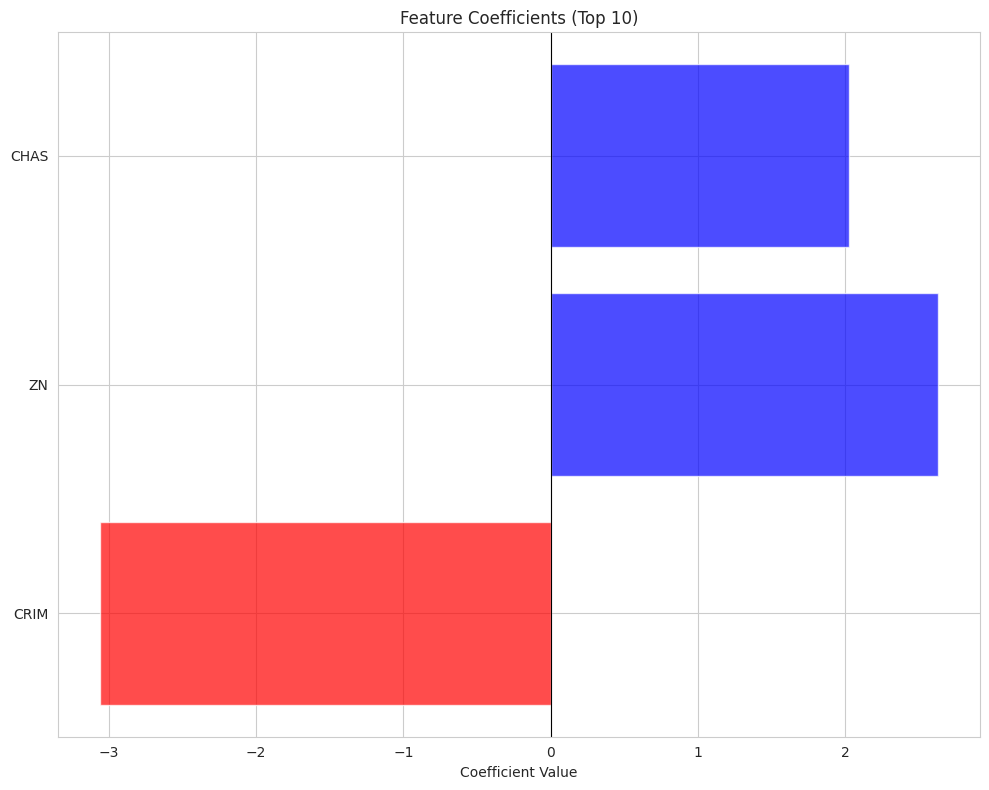

In [18]:
# Feature importance visualization
print("\n5. Feature Importance Analysis")
print("-" * 40)

# Plot feature coefficients
plt.figure(figsize=(10, 8))
coef_df_plot = coef_df.head(10)  # Top 10 features
colors = ['red' if x < 0 else 'blue' for x in coef_df_plot['Coefficient']]

plt.barh(coef_df_plot['Feature'], coef_df_plot['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients (Top 10)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.tight_layout()
plt.show()


In [20]:
# Final model summary and comparison
print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)

results_summary = pd.DataFrame({
    'Metric': ['RMSE (Train)', 'RMSE (Test)', 'R² (Train)', 'R² (Test)', 'Features Used'],
    'Value': [f"{rmse_train:.4f}", f"{rmse_test:.4f}", f"{r2_train:.4f}", f"{r2_test:.4f}", X_train.shape[1]]
})

print("Model Performance Summary:")
print(results_summary.to_string(index=False))

print(f"\nModel Interpretation:")
print(f"- The model explains {r2_test:.1%} of the variance in {target_col}")
print(f"- Average prediction error: {rmse_test:.2f}")
print(f"- Number of significant features: {len(X_train.columns)}")

if r2_test > 0.7:
    print("- Model shows good predictive performance")
elif r2_test > 0.5:
    print("- Model shows moderate predictive performance")
else:
    print("- Model shows limited predictive performance")

# Check for overfitting
if abs(r2_train - r2_test) > 0.1:
    print("- Warning: Possible overfitting detected (large train/test R² difference)")
else:
    print("- Model appears to generalize well (no significant overfitting)")

print("\nTop 3 Most Important Features:")
for i, row in coef_df.head(5).iterrows():
    impact = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"- {row['Feature']}: {impact} {target_col} (coef: {row['Coefficient']:.4f})")


FINAL RESULTS SUMMARY
Model Performance Summary:
       Metric  Value
 RMSE (Train) 8.0660
  RMSE (Test) 7.5507
   R² (Train) 0.2598
    R² (Test) 0.2349
Features Used      3

Model Interpretation:
- The model explains 23.5% of the variance in MEDV
- Average prediction error: 7.55
- Number of significant features: 3
- Model shows limited predictive performance
- Model appears to generalize well (no significant overfitting)

Top 3 Most Important Features:
- CRIM: decreases MEDV (coef: -3.0591)
- ZN: increases MEDV (coef: 2.6301)
- CHAS: increases MEDV (coef: 2.0241)
